# Predicting medical expenses

## USA patients demographic information
### Uses the dataset *medical_expenses.csv*

This notebook is an example. It does not show an exhaustive detail on all CRISP-DM phases.

(c) Nuno António 2020-2023 - Rev. 1.04

### Dataset description
Simulated dataset containing medical expenses for patients in the United States. These data were created for the book "Machine Learning with R" (Lantz, B., 2013) using demographic statistics from the U.S. Census Bureau.<br>
The variables included in this dataset are:<br>
- **age**: integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government).
- **sex**: policy holder's gender, either male or female.
- **bmi**: body mass index (BMI), which provides a sense of how over or under-weight a person is relative to their height. BMI is equal to weight (in kilograms) divided by height (in meters) squared. An ideal BMI is within the range of 18.5 to 24.9.
- **children**: integer indicating the number of children / dependents covered by the insurance plan.
- **smoker**: yes or no depending on whether the insured regularly smokes tobacco.
- **region**: beneficiary's place of residence in the U.S., divided into four geographic regions: northeast, southeast, southwest, or northwest.
- **charges**: the total medical expenses charged to the plan for the calendar year.

### Initial setup and modules/packages loading

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns
import category_encoders as ce
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from yellowbrick.model_selection import RFECV
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn import tree

### Data understanding

In [2]:
# Load data 
ds = pd.read_csv('medical_expenses.csv', sep=',')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
# Display top 15 rows
ds.head(15)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [4]:
# Summary statistics for all variables - Transpose
ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1338.0,NaN,NaN,NaN,39.207025,14.04996,18.0,27.0,39.0,51.0,64.0
sex,1338,2,male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1338.0,NaN,NaN,NaN,30.663397,6.098187,15.96,26.29625,30.4,34.69375,53.13
children,1338.0,NaN,NaN,NaN,1.094918,1.205493,0.0,0.0,1.0,2.0,5.0
smoker,1338,2,no,1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1338,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1338.0,NaN,NaN,NaN,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [5]:
# Confirm that there are not any missing values
print(ds.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [6]:
# Transform a list of columns to categorical
cols = ['sex', 'smoker', 'region']
ds[cols] = ds[cols].apply(lambda x:x.astype('category'))

In [7]:
# Ckeck the top counts of all categorical variables
categorical=ds.select_dtypes(exclude=["number","bool_","object_"]).columns.tolist()
categorical
for var in ds[categorical]:
    print(var,":\n",ds[var].value_counts(), sep="")

sex:
male      676
female    662
Name: sex, dtype: int64
smoker:
no     1064
yes     274
Name: smoker, dtype: int64
region:
southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64


In [8]:
# Exploration of categorical variables: cross table of region and smoker
tb1 = pd.crosstab(index=ds['region'], columns=ds['smoker'])
tb1

smoker,no,yes
region,,
northeast,257,67
northwest,267,58
southeast,273,91
southwest,267,58


<AxesSubplot:xlabel='region'>

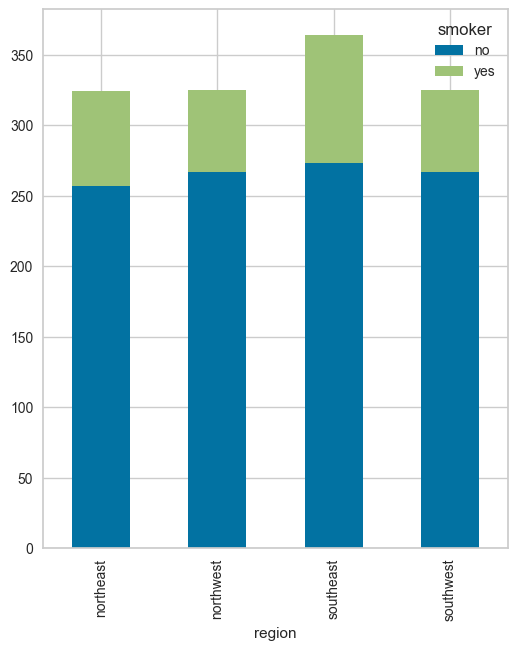

In [9]:
# Visual exploration of the cross table
tb1.plot(kind="bar", figsize=(6,7), stacked=True)

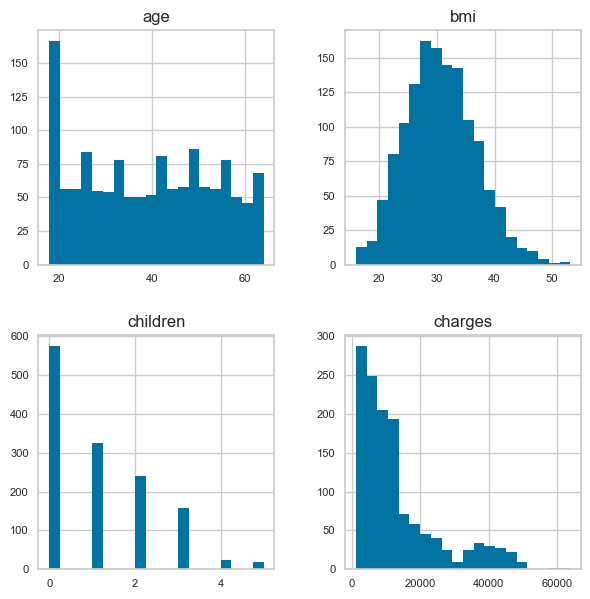

In [10]:
# Do histograms on all numeric variables
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()
ds[numerical].hist(bins=20, figsize=(7, 7), layout=(2, 2), xlabelsize=8, ylabelsize=8);

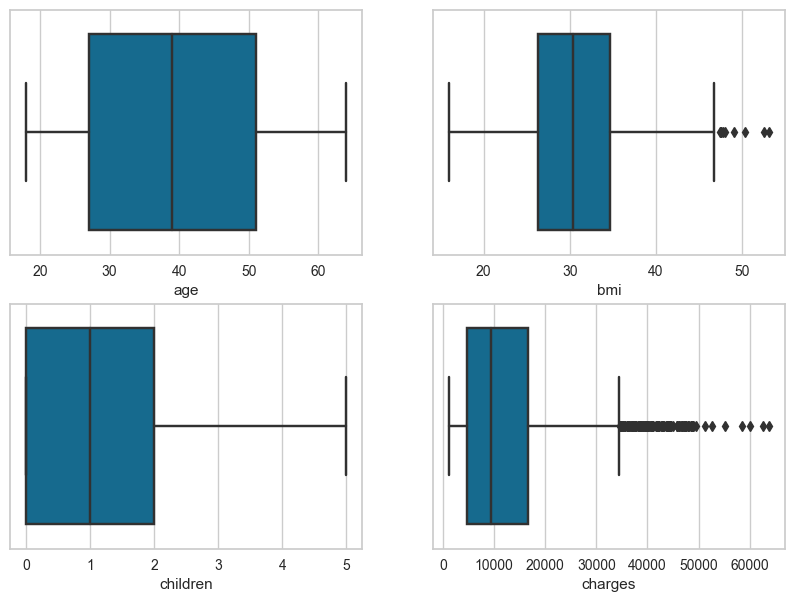

In [11]:
# Do boxplots on all numeric variables
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
for var, subplot in zip(ds[numerical], ax.flatten()):
    sns.boxplot(x=ds[var], ax=subplot)
    

/var/folders/3q/yw7kv53d5mlb0smm2tg9nkgr0000gn/T/ipykernel_69030/855079746.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


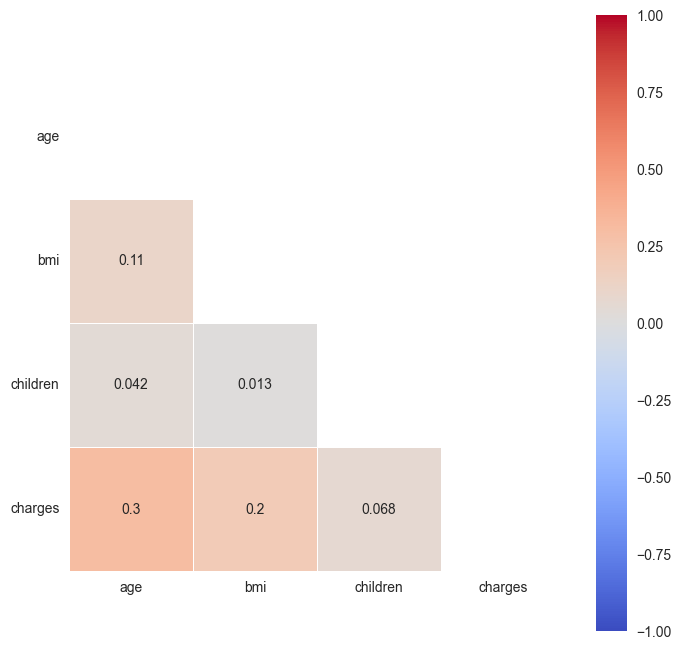

In [12]:
corr = ds[numerical].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(8, 8))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 10})

#add the column names as labels
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns, rotation = 0)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

#correct first and last line plot (bug on previous versions of Seaborn)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)

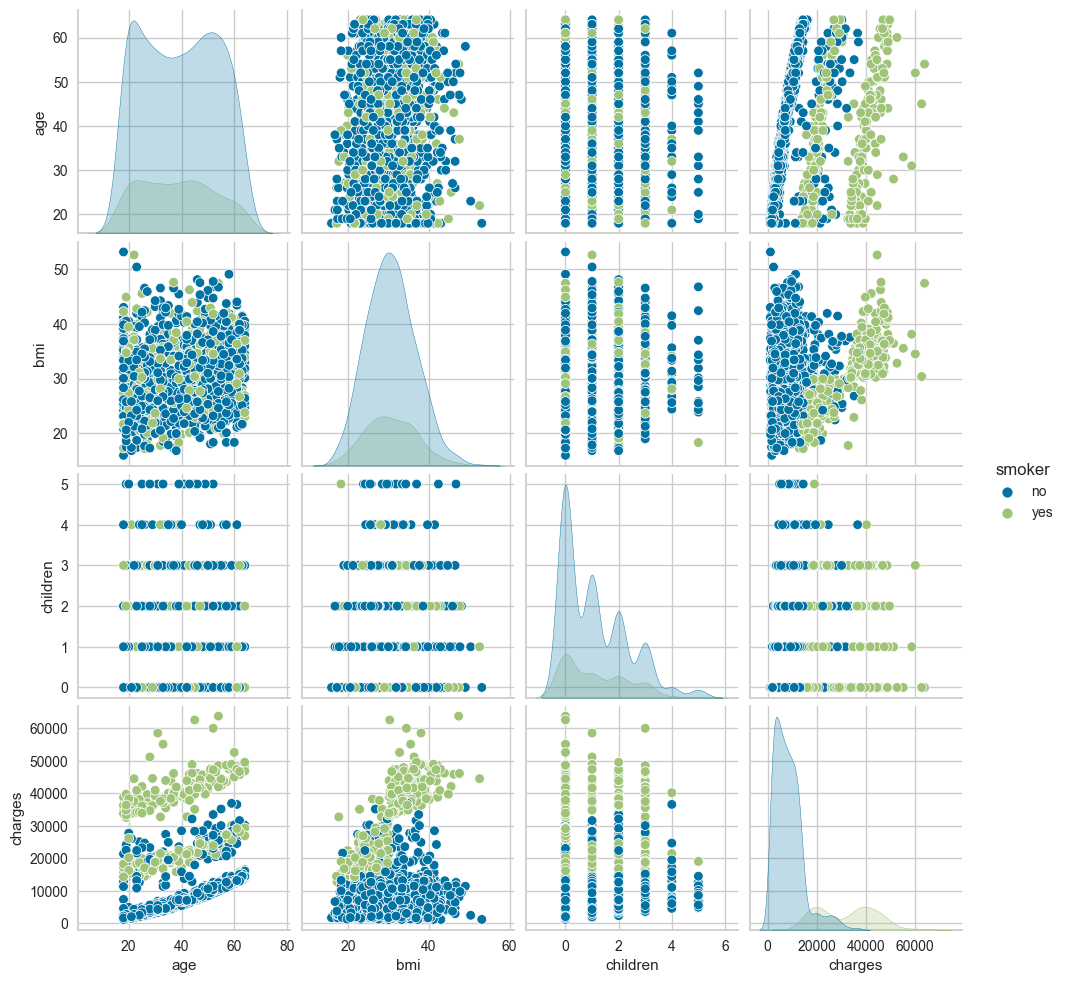

In [13]:
# Pair plot some of the numerical variables with Smoker
cols=['age','bmi','children','charges','smoker']
g = sns.pairplot(ds[cols], hue="smoker")

### Data preparation

In [14]:
# Create a modeling dataset from the original dataset
X = ds.copy(deep=True)

In [15]:
# For demo purposes, let's assume high bmi and charges values are outliers
# so let's removed them
X.drop(X[X.bmi > 50].index, inplace=True)
X.drop(X[X.charges > 60000].index, inplace=True)

In [16]:
# Bin the children for children >= 3
binsInterval = [-1, 0, 1, 2, 999]
intervalLabels = ['0', '1',  '2', '3+']
X['children_binned'] = pd.cut(X['children'], bins = binsInterval, labels=intervalLabels)

#X['children'].value_counts()
#X['children_binned'].value_counts()

In [17]:
# Bin the age
binsInterval = [0, 26, 38, 50, 99] # Create bins interval based on distribution/quartiles
intervalLabels = ['(0, 26]', '(27, 38]',  '(39, 50]', '(51, 99]']
X['age_binned'] = pd.cut(X['age'], bins = binsInterval, labels=intervalLabels)

In [18]:
X.groupby('age_binned')['bmi'].agg(meanBMI='mean')

,meanBMI
age_binned,
"(0, 26]",29.758822
"(27, 38]",30.211095
"(39, 50]",30.687410
"(51, 99]",31.650833


In [19]:
# Feature engineering
# Create a feature with the ratio of the BMI by the BMI mean of people from the same age group
bmiAgeMean = X.groupby('age_binned')['bmi'].agg(meanBMI='mean') # calculate mean by age group
X['BMIByMeanBMIRatio'] = X['bmi'].divide(bmiAgeMean.meanBMI.loc[X.age_binned].values,0) # divide ADR by mean ADR of the day

In [20]:
# Encode boolean features into dummy variables
cols = ['sex', 'smoker']
X = pd.get_dummies(data=X,columns=cols,drop_first=True)

In [21]:
# Encode categorical values into dummy variables
cols = ['region', 'age_binned', 'children_binned']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [22]:
X.shape

(1332, 19)

In [23]:
# Find and remove outliers

# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

# Find and remove outliers
cols = ['charges', 'bmi']
X = removeOutliers(X, colList=cols , lowPercentile=0.01, highPercentile=0.99, verbose=True)

           charges       bmi
0.01   1254.668530  17.88945
0.99  47918.346019  45.50590


In [24]:
X.shape

(1276, 19)

In [25]:
# Create the target
y = X['charges']

In [26]:
# Drop not used columns
cols = ['age', 'children', 'charges']
X = X.drop(columns=cols)

In [27]:
### NOT NEEDED FOR DECISION TREE ###

# Normalize all columns
# MinMax scaler returns an array, so the dataframe must be recreated
# X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X.values), columns=X.columns,index=X.index)

In [28]:
# Summary statistics for all variables after data preparation - Transpose
X.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
bmi,1276.0,30.488017,5.616574,17.955000,26.315000,30.210000,34.320000,45.430000
region_southwest,1276.0,0.242947,0.429031,0.000000,0.000000,0.000000,0.000000,1.000000
region_southeast,1276.0,0.262539,0.440187,0.000000,0.000000,0.000000,1.000000,1.000000
region_northwest,1276.0,0.249216,0.432729,0.000000,0.000000,0.000000,0.000000,1.000000
region_northeast,1276.0,0.245298,0.430432,0.000000,0.000000,0.000000,0.000000,1.000000
children_binned_0,1276.0,0.426332,0.494737,0.000000,0.000000,0.000000,1.000000,1.000000
children_binned_1,1276.0,0.241379,0.428088,0.000000,0.000000,0.000000,0.000000,1.000000
children_binned_2,1276.0,0.178683,0.383237,0.000000,0.000000,0.000000,0.000000,1.000000
children_binned_3+,1276.0,0.153605,0.360711,0.000000,0.000000,0.000000,0.000000,1.000000
"age_binned_(0, 26]",1276.0,0.239812,0.427136,0.000000,0.000000,0.000000,0.000000,1.000000


### Modeling

In [29]:
# Split the dataset intro train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, test_size = 0.25, random_state = 2021)

In [30]:
# Initialize model
tree_regr = tree.DecisionTreeRegressor(random_state=123, max_depth=4, min_samples_leaf=5)

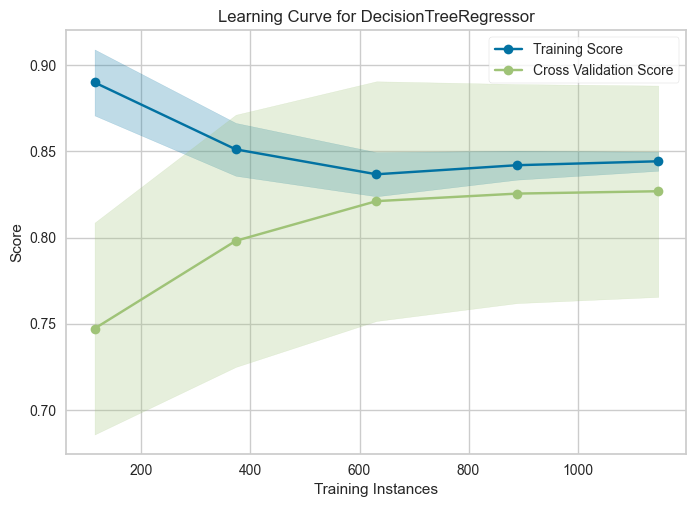

<AxesSubplot:title={'center':'Learning Curve for DecisionTreeRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [31]:
# Plot the learning curve
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=tree_regr, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=4, random_state=123)
visualizer.fit(X, y)
visualizer.show()     

In [32]:
# Create and train the model
tree_regr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, random_state=123)

In [33]:
# Explore feature importance (Gini importance - normalized)
formattedList = [float(format(member,'.6f')) for member in tree_regr.feature_importances_]
formattedList2 = [abs(float(format(member,'.6f'))) for member in tree_regr.feature_importances_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df.reset_index(drop=True, inplace=True)
coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
coeff_df

,Feature,Coefficient,AbsCoefficient
15,smoker_yes,0.710223,0.710223
0,bmi,0.166869,0.166869
12,"age_binned_(51, 99]",0.081293,0.081293
11,"age_binned_(39, 50]",0.025374,0.025374
9,"age_binned_(0, 26]",0.006929,0.006929
5,children_binned_0,0.006087,0.006087
13,BMIByMeanBMIRatio,0.001227,0.001227
4,region_northeast,0.001060,0.001060
2,region_southeast,0.000937,0.000937
1,region_southwest,0.000000,0.000000


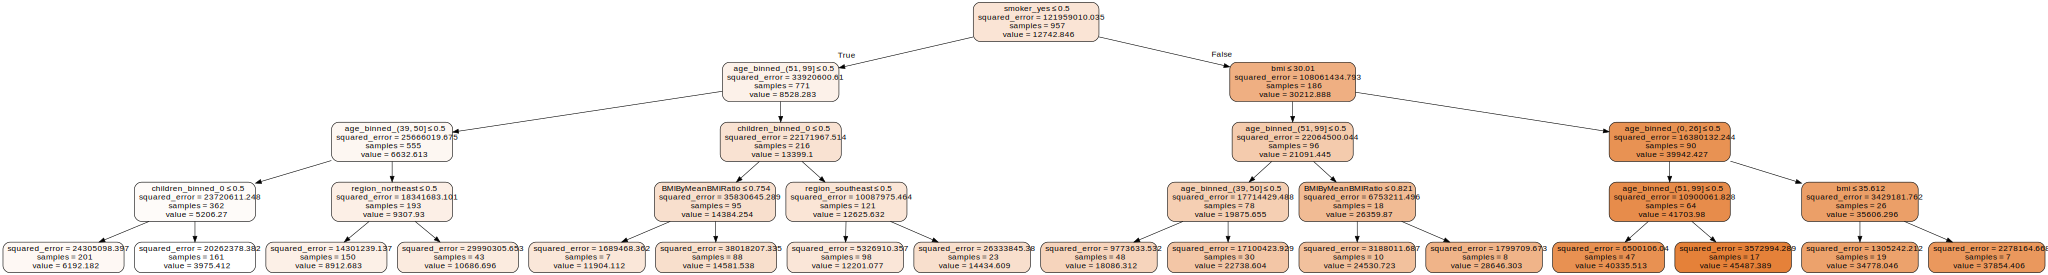

In [34]:
# Plot the tree
# Install Graphviz using "pip install graphviz" or "conda install python-graphviz"
import graphviz
dot_data = tree.export_graphviz(tree_regr, out_file=None, 
                      feature_names=list(X_train.columns),  
                      class_names='Returns',  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

<font color='blue'>C1: Explore the tree to understand the model. Remember that "values" is the average of the observations/instances in the node.</font>

### Evaluation

In [35]:
# predict y for X_train and X_test
y_pred_train = tree_regr.predict(X_train) 
y_pred_test = tree_regr.predict(X_test) 

In [36]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [37]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,2510.361183,2878.151170
1,RMSE,4276.603802,4917.223514
2,R^2,0.850037,0.826559
3,MAPE (%),0.338056,0.355066
4,MAX Error,22329.070454,21998.744584


<font color='blue'>C2: Change the algortihm parameters and re-run it to see what happens to results.</font>

/Users/nunoantonio/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


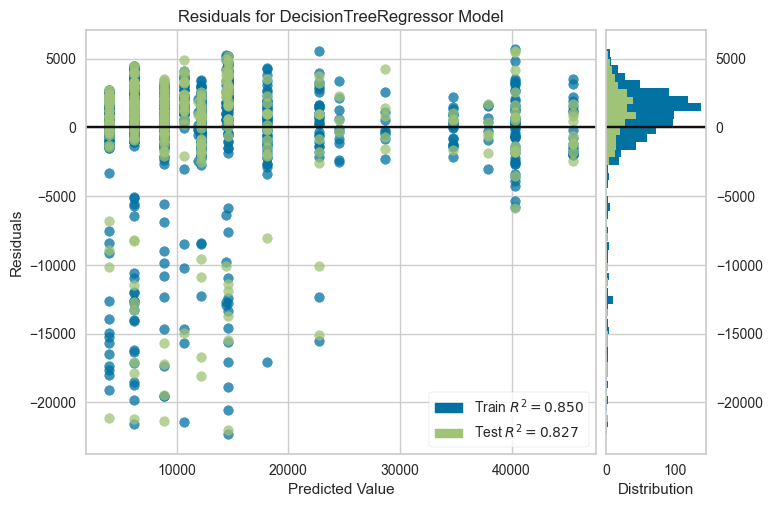

<AxesSubplot:title={'center':'Residuals for DecisionTreeRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [38]:
# Visualize the residuals
residuals_vis = ResidualsPlot(tree_regr)
residuals_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
residuals_vis.score(X_test, y_test)  # Evaluate the model on the test data
residuals_vis.show() 

/Users/nunoantonio/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


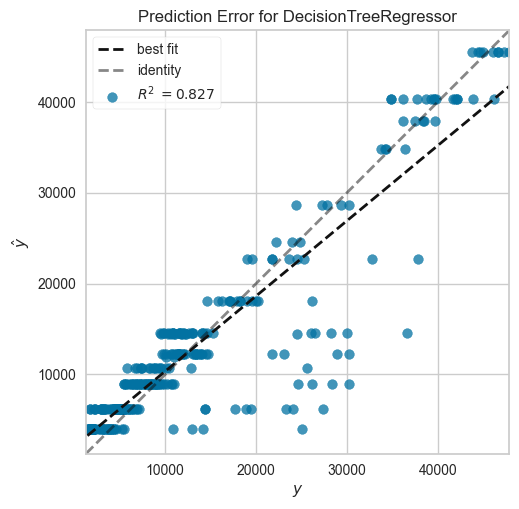

<AxesSubplot:title={'center':'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [39]:
# Visualize the prediction error
predError_vis = PredictionError(tree_regr)
predError_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
predError_vis.score(X_test, y_test)  # Evaluate the model on the test data
predError_vis.show() 
